In [1]:
import pandas as pd
import geopandas as gpd
from siuba import *

HQTA_PATH = 'gs://calitp-analytics-data/data-analyses/high_quality_transit_areas/export/2024-09-18/ca_hq_transit_areas.parquet'

In [2]:
processed_census_path = 'gs://calitp-analytics-data/data-analyses/sb125/quick_mts_jobs/'

In [3]:
from calitp_data_analysis.utils import geoparquet_gcs_export

# Quick counts of people and jobs within ~0.5mi of a Major Transit Stop

Just wrapped this up, attached are two csvs. One summarizes jobs and population within a half mile of the various types of Major Transit Stop per PRC 21155 and PRC 21064.3, the other additionally separates them out by transit agency.

Used 2020 Census LEHD Workplace Area Characteristics to get all primary jobs by Census block, population by block is from the 2020 decennial Census. Spatial join was a simple intersection of each half-mile buffer around a major transit stop with all Census blocks, then jobs and people were summed across all those blocks to get a single figure per major stop.


## read clean census (already done, output on GCS)

In [ ]:
import gzip
# all workers, all primary jobs
with gzip.open('./ca_wac_S000_JT01_2021.csv.gz', 'rb') as f:
    df = pd.read_csv(f)

In [ ]:
df = df.iloc[:, :2]

In [ ]:
import zipfile

In [ ]:
with zipfile.ZipFile('./DECENNIALPL2020.P1_2024-10-16T105517.zip', 'r') as myzip:
    with myzip.open('DECENNIALPL2020.P1-Data.csv') as f:
        df2 = pd.read_csv(f)

In [ ]:
df2 = df2.iloc[1:,:3]

In [ ]:
df2.GEO_ID = df2.GEO_ID.map(lambda x: x[10:])

In [ ]:
df2.GEO_ID = df2.GEO_ID.astype(int)

In [ ]:
df2.P1_001N = df2.P1_001N.astype(int)

In [ ]:
df2 >> head(3)

In [ ]:
df2.dtypes

In [ ]:
df >> head(3)

In [ ]:
df.dtypes

In [ ]:
joined = df2 >> inner_join(_, df, on={'GEO_ID':'w_geocode'})

In [ ]:
joined

In [ ]:
hqta >> head(3)

In [ ]:
blocks = gpd.read_file('./tl_2020_06_tabblock20.zip')

In [ ]:
blocks = blocks >> select(_.GEOID20, _.POP20, _.HOUSING20, _.geometry)

In [ ]:
blocks.GEOID20 = blocks.GEOID20.astype(int)

In [ ]:
blocks = blocks >> rename(GEO_ID = _.GEOID20)

In [ ]:
joined = blocks >> inner_join(_, joined, on='GEO_ID')

In [ ]:
joined

In [ ]:
joined = joined >> select(_.geoid == _.GEO_ID, _.pop == _.POP20, _.jobs == _.C000,
                          _.housing == _.HOUSING20, _.geometry)

In [ ]:
joined.to_parquet('census_jobs_blocks.parquet')

In [ ]:
geoparquet_gcs_export(joined, processed_census_path, 'census_jobs_blocks.parquet')

## Spatial Join (start here)

In [4]:
census = gpd.read_parquet(f'{processed_census_path}census_jobs_blocks.parquet').rename(columns={'pop': 'people'})

In [5]:
hqta = gpd.read_parquet(HQTA_PATH)

In [6]:
hqta = hqta >> select(_.agency_primary, _.hqta_type, _.geometry) >> filter(_.hqta_type != 'hq_corridor_bus')

In [7]:
from calitp_data_analysis import geography_utils

In [8]:
hqta = hqta.to_crs(geography_utils.CA_NAD83Albers)

In [9]:
census = census.to_crs(geography_utils.CA_NAD83Albers)

In [10]:
sjoined = census.sjoin(hqta, how="inner", predicate='intersects') # flip direction to calculate area
sjoined = sjoined >> rename(hqta_ix = _.index_right)

In [11]:
# hqta = hqta.reset_index().rename(columns={'index':'hqta_ix'}) #  might actually have use for an ix
# sjoined = hqta.sjoin(census, how="inner", predicate='intersects')

In [12]:
from shared_utils.rt_utils import METERS_PER_MILE
sq_m_per_sq_mi = METERS_PER_MILE**2

In [13]:
sq_m_per_sq_mi

2589975.2356

In [14]:
sjoined = sjoined >> mutate(area_sq_mi = _.geometry.map(lambda x: x.area / sq_m_per_sq_mi))

In [15]:
sj_geo = sjoined.copy()

In [16]:
sjoined = sjoined >> select(-_.geometry, -_.index_right)

In [17]:
sjoined >> head(3)

,geoid,people,jobs,housing,hqta_ix,agency_primary,hqta_type,area_sq_mi
1,61130101032011,0,503,0,46833,Yolo County Transportation District,major_stop_bus,0.058746
3933,61130102011037,0,24,0,46833,Yolo County Transportation District,major_stop_bus,0.031665
4436,61130102042002,53,12,23,46833,Yolo County Transportation District,major_stop_bus,0.009574


In [18]:
(sjoined >> distinct(_.geoid, _.people)).sum()

geoid     6217363199145780985
people               15073821
dtype: int64

In [19]:
stop_grouped = (sjoined >> group_by(_.hqta_ix, _.agency_primary, _.hqta_type)
                >> summarize(total_jobs = _.jobs.sum(), total_pop = _.people.sum(),
                            total_housing = _.housing.sum(), total_sq_mi = _.area_sq_mi.sum(),
                            n = _.shape[0])
               )

In [20]:
(sjoined >> filter(_.hqta_ix == 8241)).sum()

geoid                                             12210775559444427
people                                                        71224
jobs                                                          27877
housing                                                       45230
hqta_ix                                                     1656441
agency_primary    City and County of San FranciscoCity and Count...
hqta_type         major_stop_busmajor_stop_busmajor_stop_busmajo...
area_sq_mi                                                 0.950171
dtype: object

In [21]:
stop_grouped >> arrange(-_.total_pop)

,hqta_ix,agency_primary,hqta_type,total_jobs,total_pop,total_housing,total_sq_mi,n
5672,8241,City and County of San Francisco,major_stop_bus,27877,71224,45230,0.950171,201
5907,8476,City and County of San Francisco,major_stop_bus,28269,70226,45748,0.917606,210
5673,8242,City and County of San Francisco,major_stop_bus,40235,68901,43811,0.934889,212
5929,8498,City and County of San Francisco,major_stop_bus,43298,68639,43643,0.938074,213
5927,8496,City and County of San Francisco,major_stop_bus,49917,68386,43665,0.949875,209
...,...,...,...,...,...,...,...,...
46379,48949,San Francisco International Airport,major_stop_rail,8801,0,0,2.908523,3
46380,48950,San Francisco International Airport,major_stop_rail,8801,0,0,2.908523,3
46387,48957,San Francisco International Airport,major_stop_rail,8801,0,0,2.908523,3
46388,48958,San Francisco International Airport,major_stop_rail,8801,0,0,2.908523,3


In [22]:
stop_grouped.describe()

,hqta_ix,total_jobs,total_pop,total_housing,total_sq_mi,n
count,46660.000000,46660.000000,46660.000000,46660.000000,46660.000000,46660.000000
mean,25898.547342,16830.931740,12320.326704,5608.475439,1.207810,77.852036
std,13469.804237,36277.232701,9483.377655,5853.560702,0.952010,44.769746
min,2569.000000,5.000000,0.000000,0.000000,0.155600,2.000000
25%,14233.750000,2483.000000,6258.750000,2326.000000,0.921196,42.000000
50%,25898.500000,5049.000000,9988.000000,3666.000000,1.039169,70.000000
75%,37563.250000,11998.750000,15475.000000,6333.000000,1.293047,104.000000
max,49229.000000,255743.000000,71224.000000,45748.000000,153.077307,317.000000


In [23]:
def group_calculate(df, grouper, normalize=False):
    if normalize:
        df.total_pop = df.total_pop / df.total_sq_mi
        df.total_jobs = df.total_jobs / df.total_sq_mi
        df.total_housing = df.total_housing / df.total_sq_mi
    df = stop_grouped >> grouper >> summarize(
                            p5_pop = _.total_pop.quantile(.05), p20_pop = _.total_pop.quantile(.2),
                            p50_pop = _.total_pop.quantile(.5), 
                            p80_pop = _.total_pop.quantile(.8), p95_pop = _.total_pop.quantile(.95),
                            p5_jobs = _.total_jobs.quantile(.05),
                            p20_jobs = _.total_jobs.quantile(.2), p50_jobs = _.total_jobs.quantile(.5),
                            p80_jobs = _.total_jobs.quantile(.8), p95_jobs = _.total_jobs.quantile(.95),
                            p5_housing = _.total_housing.quantile(.05),
                            p20_housing = _.total_housing.quantile(.2), p50_housing = _.total_housing.quantile(.5),
                            p80_housing = _.total_housing.quantile(.8), p95_housing = _.total_housing.quantile(.95)
                        )
    if normalize:
        new_names = df.columns.map(lambda x: x+'_per_sq_mi')
        rename_dict = dict(zip(df.columns, new_names))
        df = df.rename(columns=rename_dict)
    return df.round(1)

In [24]:
by_type = group_calculate(stop_grouped, group_by(_.hqta_type), normalize=False)
by_type

,hqta_type,p5_pop,p20_pop,p50_pop,p80_pop,p95_pop,p5_jobs,p20_jobs,p50_jobs,p80_jobs,p95_jobs,p5_housing,p20_housing,p50_housing,p80_housing,p95_housing
0,major_stop_brt,7201.0,14900.6,23434.5,35540.0,58089.4,1308.4,3961.4,12188.5,80472.4,204147.0,2334.8,4954.4,11311.0,21936.0,36266.9
1,major_stop_bus,2505.0,5479.0,9829.0,16966.0,27301.0,1028.0,2119.0,4878.0,14676.0,77209.0,953.0,2090.0,3606.0,7134.0,17160.0
2,major_stop_ferry,507.8,3172.0,6880.0,10316.2,11707.0,1033.4,1679.0,14020.0,123292.6,135427.7,210.4,1704.0,4143.0,6906.2,7761.0
3,major_stop_rail,2227.7,6191.0,11971.0,25451.6,56594.0,1377.7,3110.8,8994.0,45033.0,217600.0,855.3,2482.0,5220.0,15627.0,32754.0


In [25]:
by_type_norm = group_calculate(stop_grouped, group_by(_.hqta_type), normalize=True)
by_type_norm

,hqta_type_per_sq_mi,p5_pop_per_sq_mi,p20_pop_per_sq_mi,p50_pop_per_sq_mi,p80_pop_per_sq_mi,p95_pop_per_sq_mi,p5_jobs_per_sq_mi,p20_jobs_per_sq_mi,p50_jobs_per_sq_mi,p80_jobs_per_sq_mi,p95_jobs_per_sq_mi,p5_housing_per_sq_mi,p20_housing_per_sq_mi,p50_housing_per_sq_mi,p80_housing_per_sq_mi,p95_housing_per_sq_mi
0,major_stop_brt,6640.1,15436.7,24445.2,37133.6,63053.3,1299.3,4303.8,11998.4,85633.4,218470.9,2413.7,5149.8,12596.6,22679.6,38742.2
1,major_stop_bus,1611.4,4462.0,8929.4,17290.6,29238.9,825.8,1826.6,4329.2,13040.5,84565.7,654.9,1696.9,3242.9,7230.9,18680.4
2,major_stop_ferry,421.7,2915.8,14225.9,22488.0,25607.5,669.3,2732.9,22290.7,274160.5,287714.1,194.5,1521.3,9045.7,15133.4,16976.2
3,major_stop_rail,1542.4,4661.7,12003.7,28246.4,60329.3,1160.2,2823.7,7614.2,50991.3,258973.0,524.7,1888.5,4844.0,17819.6,34478.3


In [26]:
by_agency = group_calculate(stop_grouped, group_by(_.hqta_type, _.agency_primary), normalize=False)
by_agency

,hqta_type,agency_primary,p5_pop,p20_pop,p50_pop,p80_pop,p95_pop,p5_jobs,p20_jobs,p50_jobs,p80_jobs,p95_jobs,p5_housing,p20_housing,p50_housing,p80_housing,p95_housing
0,major_stop_brt,Alameda-Contra Costa Transit District,11384.2,13029.7,17101.5,18747.5,22483.9,1064.5,1313.9,4300.4,7434.9,72900.3,3414.5,4603.6,5160.4,8453.5,13862.3
1,major_stop_brt,City and County of San Francisco,16828.8,24270.7,30182.5,51135.6,68909.1,4340.7,8158.7,18413.6,98015.6,236992.6,8523.5,11815.6,17318.7,28692.2,41951.5
2,major_stop_brt,Los Angeles County Metropolitan Transportation...,3355.4,6342.8,13073.8,18115.8,23438.5,986.6,2049.0,5015.2,12672.1,125966.3,1295.5,2278.6,4777.3,6766.8,14945.4
3,major_stop_bus,Alameda-Contra Costa Transit District,3837.3,8035.7,12197.4,17433.2,23554.1,684.3,1377.9,3273.0,8774.5,60164.1,1517.4,3070.5,4750.7,7521.4,13572.8
4,major_stop_bus,Amador Regional Transit System,98.7,133.9,133.9,139.8,8752.9,141.0,142.2,142.2,146.2,72964.8,64.6,82.3,82.3,86.4,4404.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,major_stop_rail,San Francisco International Airport,0.0,0.0,200.9,1103.0,1540.1,2850.7,2873.6,3025.9,3954.0,4080.3,0.0,0.0,61.2,358.3,506.9
158,major_stop_rail,San Joaquin Regional Rail Commission,626.6,1957.2,4135.1,6603.9,12333.9,758.3,1390.4,4281.7,9627.7,15993.5,244.3,519.0,1642.1,2644.1,5345.9
159,major_stop_rail,Santa Clara Valley Transportation Authority,256.1,2416.4,7539.0,11574.3,15072.2,1202.0,3695.0,9838.7,24311.4,41230.6,73.0,1189.9,3157.9,5318.4,8695.6
160,major_stop_rail,Sonoma-Marin Area Rail Transit District,764.3,1846.8,3569.5,6167.1,9330.7,463.4,1074.2,2482.0,3833.8,5301.5,353.9,727.1,1579.7,2845.7,3614.0


In [27]:
by_agency_norm = group_calculate(stop_grouped, group_by(_.hqta_type, _.agency_primary), normalize=True)
by_agency_norm

,hqta_type_per_sq_mi,agency_primary_per_sq_mi,p5_pop_per_sq_mi,p20_pop_per_sq_mi,p50_pop_per_sq_mi,p80_pop_per_sq_mi,p95_pop_per_sq_mi,p5_jobs_per_sq_mi,p20_jobs_per_sq_mi,p50_jobs_per_sq_mi,p80_jobs_per_sq_mi,p95_jobs_per_sq_mi,p5_housing_per_sq_mi,p20_housing_per_sq_mi,p50_housing_per_sq_mi,p80_housing_per_sq_mi,p95_housing_per_sq_mi
0,major_stop_brt,Alameda-Contra Costa Transit District,10542.6,13056.2,17563.1,20945.3,28295.8,1125.7,1372.9,4501.8,8073.8,91353.2,3002.5,4809.1,5428.3,9640.5,17202.4
1,major_stop_brt,City and County of San Francisco,16634.4,26624.2,33003.2,53751.4,74513.8,3913.7,9214.3,19937.6,106585.2,254559.6,7743.7,12936.4,18731.6,31047.9,46269.3
2,major_stop_brt,Los Angeles County Metropolitan Transportation...,3120.4,6085.7,14222.1,21294.7,30231.7,999.0,2104.1,4754.1,13556.5,133587.0,1204.8,2118.9,4809.0,6676.8,17633.7
3,major_stop_bus,Alameda-Contra Costa Transit District,2395.4,6745.5,12696.7,19940.5,27670.7,435.5,1257.5,3197.9,9683.5,75937.8,886.6,2593.1,5076.9,8692.7,16396.4
4,major_stop_bus,Amador Regional Transit System,14.1,18.8,18.8,19.4,10667.0,20.0,20.0,20.1,20.3,88949.1,9.2,11.6,11.6,12.0,5366.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,major_stop_rail,San Francisco International Airport,0.0,0.0,65.0,440.0,786.2,914.9,930.1,1040.4,1806.9,2065.3,0.0,0.0,19.8,147.2,258.8
158,major_stop_rail,San Joaquin Regional Rail Commission,430.4,949.7,2656.3,7853.0,13238.8,357.9,1133.4,2672.6,7719.8,18920.3,135.6,283.5,1058.5,3214.0,5925.5
159,major_stop_rail,Santa Clara Valley Transportation Authority,106.4,1463.6,6257.9,12088.5,19079.9,883.1,2522.2,7111.7,21609.1,53574.0,37.2,753.7,2385.7,5602.9,11049.7
160,major_stop_rail,Sonoma-Marin Area Rail Transit District,271.4,562.8,2318.2,4035.3,7803.2,120.7,368.8,1183.0,3221.8,3774.3,116.6,221.6,1020.7,1862.0,3019.5


In [28]:
# by_type.to_csv('pop_jobs_housing_by_major_stop_type.csv')
# by_type_norm.to_csv('pop_jobs_housing_by_major_stop_type_sq_mi.csv')
# by_agency.to_csv('pop_jobs_housing_by_major_stop_type_and_agency.csv')
# by_agency_norm.to_csv('pop_jobs_housing_by_major_stop_type_and_agency_sq_mi.csv')

## spot-checks

In [26]:
sjoined.geoid = sjoined.geoid.astype(str)

In [27]:
sjoined

,geoid,people,jobs,housing,hqta_ix,agency_primary,hqta_type,area_sq_mi
1,61130101032011,0,503,0,46833,Yolo County Transportation District,major_stop_bus,0.058746
3933,61130102011037,0,24,0,46833,Yolo County Transportation District,major_stop_bus,0.031665
4436,61130102042002,53,12,23,46833,Yolo County Transportation District,major_stop_bus,0.009574
5017,61130102042011,0,20,0,46833,Yolo County Transportation District,major_stop_bus,0.005923
5673,61130102011043,49,1,28,46833,Yolo County Transportation District,major_stop_bus,0.008385
...,...,...,...,...,...,...,...,...
247980,60450109003011,40,42,17,33628,Mendocino Transit Authority,major_stop_bus,0.407573
180366,60450109003041,0,4,0,33627,Mendocino Transit Authority,major_stop_bus,0.174335
245059,60450109001092,22,5,9,33627,Mendocino Transit Authority,major_stop_bus,2.219659
245419,60450109003031,19,7,5,33627,Mendocino Transit Authority,major_stop_bus,0.211296


In [67]:
import numpy as np

In [42]:
test_tract = '6037271801'

In [43]:
test = sjoined >> filter(_.geoid.str.contains(test_tract))

In [44]:
test >> distinct(_.geoid, _keep_all=True)

,geoid,people,jobs,housing,hqta_ix,agency_primary,hqta_type,area_sq_mi
0,60372718013000,530,11,239,12116,City of Culver City,major_stop_bus,0.024759
1,60372718012004,1343,66,823,12116,City of Culver City,major_stop_bus,0.031084
2,60372718011005,383,13,164,12116,City of Culver City,major_stop_bus,0.019604
3,60372718012005,207,25,111,12116,City of Culver City,major_stop_bus,0.009141
4,60372718011002,216,1,92,12192,City of Culver City,major_stop_bus,0.009337
5,60372718011003,108,28,52,12192,City of Culver City,major_stop_bus,0.008104
6,60372718012000,147,3,67,12183,City of Culver City,major_stop_bus,0.011464
7,60372718012001,127,2,51,12183,City of Culver City,major_stop_bus,0.009505
8,60372718012002,152,14,56,12183,City of Culver City,major_stop_bus,0.010094
9,60372718011001,90,1,35,12183,City of Culver City,major_stop_bus,0.010074


In [45]:
(test >> distinct(_.geoid, _keep_all=True)).sum()

geoid             6037271801300060372718012004603727180110056037...
people                                                         3666
jobs                                                            302
housing                                                        1835
hqta_ix                                                      158129
agency_primary    City of Culver CityCity of Culver CityCity of ...
hqta_type         major_stop_busmajor_stop_busmajor_stop_busmajo...
area_sq_mi                                                  0.17768
dtype: object

In [46]:
3666 / 0.17768

20632.597928860872

In [57]:
sj_geo['pop_sq_mi'] = sj_geo.people / sj_geo.area_sq_mi

In [58]:
sj_geo >> head(3)

,geoid,people,jobs,housing,geometry,hqta_ix,agency_primary,hqta_type,area_sq_mi,pop_sq_mi
1,61130101032011,0,503,0,"POLYGON ((-133704.516 64689.898, -133482.394 6...",46833,Yolo County Transportation District,major_stop_bus,0.058746,0.000000
3933,61130102011037,0,24,0,"POLYGON ((-132535.600 62760.752, -132493.242 6...",46833,Yolo County Transportation District,major_stop_bus,0.031665,0.000000
4436,61130102042002,53,12,23,"POLYGON ((-133743.507 63658.957, -133742.343 6...",46833,Yolo County Transportation District,major_stop_bus,0.009574,5535.764044


In [59]:
sj_geo >> arrange(-_.pop_sq_mi)

,geoid,people,jobs,housing,geometry,hqta_ix,agency_primary,hqta_type,area_sq_mi,pop_sq_mi
70452,60730051032002,2311,6,81,"POLYGON ((267533.858 -585535.409, 267551.134 -...",38209,San Diego International Airport,major_stop_bus,0.003853,599832.547485
70452,60730051032002,2311,6,81,"POLYGON ((267533.858 -585535.409, 267551.134 -...",22997,Flagship Cruises and Events Inc.,major_stop_bus,0.003853,599832.547485
70452,60730051032002,2311,6,81,"POLYGON ((267533.858 -585535.409, 267551.134 -...",38700,San Diego International Airport,major_stop_bus,0.003853,599832.547485
70452,60730051032002,2311,6,81,"POLYGON ((267533.858 -585535.409, 267551.134 -...",40501,San Diego Metropolitan Transit System,major_stop_bus,0.003853,599832.547485
70452,60730051032002,2311,6,81,"POLYGON ((267533.858 -585535.409, 267551.134 -...",39686,San Diego Metropolitan Transit System,major_stop_bus,0.003853,599832.547485
...,...,...,...,...,...,...,...,...,...,...
220792,60819843001014,0,4,0,"POLYGON ((-211495.183 -41299.500, -211468.118 ...",40886,San Francisco International Airport,major_stop_bus,0.084919,0.000000
180366,60450109003041,0,4,0,"POLYGON ((-278843.254 135202.152, -278825.311 ...",25224,Lake Transit Authority,major_stop_bus,0.174335,0.000000
180366,60450109003041,0,4,0,"POLYGON ((-278843.254 135202.152, -278825.311 ...",33629,Mendocino Transit Authority,major_stop_bus,0.174335,0.000000
180366,60450109003041,0,4,0,"POLYGON ((-278843.254 135202.152, -278825.311 ...",33628,Mendocino Transit Authority,major_stop_bus,0.174335,0.000000


In [131]:
# (sj_geo >> filter(_.hqta_ix == 38209)).explore()

In [63]:
(sj_geo >> filter(_.hqta_ix == 38209)).sum()

/tmp/ipykernel_460/2661624186.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (sj_geo >> filter(_.hqta_ix == 38209)).sum()


geoid                                              8684397483496020
people                                                        23721
jobs                                                          19005
housing                                                       16057
hqta_ix                                                     5463887
agency_primary    San Diego International AirportSan Diego Inter...
hqta_type         major_stop_busmajor_stop_busmajor_stop_busmajo...
area_sq_mi                                                 0.896213
pop_sq_mi                                            5229157.387554
dtype: object

In [64]:
23721 / 0.896213

26468.03829000472

In [68]:
stop_dis = sj_geo.dissolve(by='hqta_ix', aggfunc=[np.sum])

In [70]:
stop_dis.columns

Index([               'geometry',          ('geoid', 'sum'),
               ('people', 'sum'),           ('jobs', 'sum'),
              ('housing', 'sum'), ('agency_primary', 'sum'),
            ('hqta_type', 'sum'),     ('area_sq_mi', 'sum'),
            ('pop_sq_mi', 'sum')],
      dtype='object')

In [73]:
rename_dict = dict(zip(stop_dis.columns, [col[0] for col in stop_dis.columns]))
rename_dict['geometry'] = 'geometry'

In [75]:
stop_dis = stop_dis.rename(columns=rename_dict)

In [84]:
stop_dis = stop_dis >> select(-_.agency_primary, -_.hqta_type)

In [85]:
stop_dis.pop_sq_mi = stop_dis.people / stop_dis.area_sq_mi

In [86]:
stop_dis.pop_sq_mi.quantile(.8)

17971.84847190569

<AxesSubplot:>

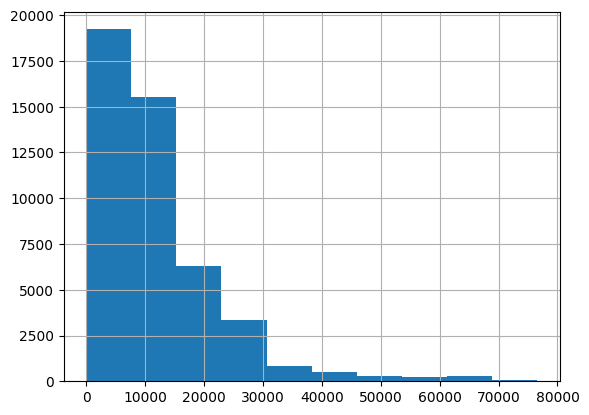

In [87]:
stop_dis.pop_sq_mi.hist()

In [129]:
# (stop_dis >> filter(_.pop_sq_mi > 50000)).explore()

In [89]:
stop_dis.pop_sq_mi.max()

76531.73514322769

In [130]:
# (stop_dis >> filter(_.pop_sq_mi > 70000)).explore()

In [119]:
stop_dis.loc[8241,:]

geometry      POLYGON ((-213488.63960879878 -23210.707868514...
geoid                                         12210775559444427
people                                                    71224
jobs                                                      27877
housing                                                   45230
area_sq_mi                                             0.950171
pop_sq_mi                                          74959.158474
Name: 8241, dtype: object

In [100]:
stop_dis.loc[8732:8733,:].geometry.area / sq_m_per_sq_mi

hqta_ix
8732    0.888816
8733    0.907315
dtype: float64

In [120]:
stop_dis >> arrange(-_.pop_sq_mi)

,geometry,geoid,people,jobs,housing,area_sq_mi,pop_sq_mi
hqta_ix,,,,,,,
8476,"POLYGON ((-213226.581 -22961.092, -213228.506 ...",12757525843307442,70226,28269,45748,0.917606,76531.735143
8241,"POLYGON ((-213488.640 -23210.708, -213503.112 ...",12210775559444427,71224,27877,45230,0.950171,74959.158474
8732,"POLYGON ((-213259.958 -23815.279, -213266.975 ...",11238775275165421,66484,57384,41370,0.888816,74800.667691
8477,"POLYGON ((-213205.156 -22948.963, -213228.506 ...",13182776142213502,67877,33994,43688,0.909333,74644.807290
2706,"POLYGON ((-213260.263 -23603.652, -213432.864 ...",11421024465681402,66666,31139,42192,0.893533,74609.416421
...,...,...,...,...,...,...,...
48949,"POLYGON ((-211468.118 -41299.629, -211457.979 ...",182459529003022,0,8801,0,2.908523,0.000000
48950,"POLYGON ((-211468.118 -41299.629, -211457.979 ...",182459529003022,0,8801,0,2.908523,0.000000
48957,"POLYGON ((-211468.118 -41299.629, -211457.979 ...",182459529003022,0,8801,0,2.908523,0.000000


In [101]:
from shared_utils.rt_utils import show_full_df

In [122]:
stop_grouped['pop_sq_mi'] = stop_grouped.total_pop / stop_grouped.total_sq_mi

In [123]:
stop_grouped >> arrange(-_.pop_sq_mi)

,hqta_ix,agency_primary,hqta_type,total_jobs,total_pop,total_housing,total_sq_mi,n,pop_sq_mi
5907,8476,City and County of San Francisco,major_stop_bus,28269,70226,45748,0.917606,210,76531.735143
5672,8241,City and County of San Francisco,major_stop_bus,27877,71224,45230,0.950171,201,74959.158474
6163,8732,City and County of San Francisco,major_stop_bus,57384,66484,41370,0.888816,185,74800.667691
5908,8477,City and County of San Francisco,major_stop_bus,33994,67877,43688,0.909333,217,74644.807290
137,2706,City and County of San Francisco,major_stop_brt,31139,66666,42192,0.893533,188,74609.416421
...,...,...,...,...,...,...,...,...,...
46379,48949,San Francisco International Airport,major_stop_rail,8801,0,0,2.908523,3,0.000000
46380,48950,San Francisco International Airport,major_stop_rail,8801,0,0,2.908523,3,0.000000
46387,48957,San Francisco International Airport,major_stop_rail,8801,0,0,2.908523,3,0.000000
46388,48958,San Francisco International Airport,major_stop_rail,8801,0,0,2.908523,3,0.000000


In [114]:
# show_full_df(sjoined >> filter(_.hqta_ix == 8732))